# Data Mining CS 619, Spring 2018 - Eleonora Renz

### Week 7 - Chapter 7

## Follow Recommendations Using Graph Mining

We are going to create a small social graph from Twitter using the API we introduced in the
previous chapter. The data we are looking for is a subset of users interested in a similar
topic (again, the Python programming language) and a list of all of their friends (people
they follow). With this data, we will check how similar two users are, based on how many
friends they have in common.

#### Loading th dataset

In [1]:
import twitter

consumer_key = "fjWS8WLO6iR6ZSi22lCt0XwJO"
consumer_secret = "3dQXyQdcM21vpDklxqnYPpCFMGsdJZnEI0xG6u5jp9J6fU7cSY"
access_token = "840475426162110464-dR342dwz0THqN4aI01nBCkGQ9aOJc0e"
access_token_secret = "UByuQL9sTe7UhoNwqtnlJFZ75cFxsJJOmYgqYoTyoBaVv"
authorization = twitter.OAuth(access_token, access_token_secret, consumer_key, consumer_secret)
t = twitter.Twitter(auth=authorization, retry=True)

In [2]:
import os

data_folder = os.path.join(os.path.expanduser("~"), "Desktop", "DataMining_Spring2018", "Data", "twitter", "follow_rec")
output_filename = os.path.join(data_folder, "python_tweets.json")

original_users = [] 
tweets = []
user_ids = {}

In [3]:
# Search for tweets with the word "python"
search_results = t.search.tweets(q="python", count=100)['statuses']
for tweet in search_results:
    if 'text' in tweet:
        original_users.append(tweet['user']['screen_name'])
        user_ids[tweet['user']['screen_name']] = tweet['user']['id']
        tweets.append(tweet['text'])

#### Classifying with an existing model

In [4]:
# Classifie is the tweet is talking about the programming language Python
model_filename = os.path.join(os.path.expanduser("~"), "Desktop", "DataMining_Spring2018", "Models", "twitter", "python_context.pkl")

In [5]:
# Create Bag of Words class
import spacy
from sklearn.base import TransformerMixin

#Create a spacy parser
nlp = spacy.load('en_core_web_sm')

class BagOfWords(TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        results = []
        for document in x:
            row = {}
            for word in list(nlp(document)):
                if len(word.text.strip()): # Ignore words that are just whitespace
                    row[word.text] = True
                    results.append(row)
        return results

In [6]:
# Load the model
from sklearn.externals import joblib
context_classifier = joblib.load(model_filename)

# Predict if a tweet is relavent to us
y_pred = context_classifier.predict(tweets)

relevant_tweets = [tweets[i] for i in range(len(tweets)) if y_pred[i] == 1]
relevant_users = [original_users[i] for i in range(len(tweets)) if y_pred[i] == 1]

#### Getting follower information from Twitter

In [7]:
import time

def get_friends(t, user_id):
    friends = []
    cursor = -1
    while cursor != 0: 
        try:
            results = t.friends.ids(user_id= user_id, cursor=cursor, count=5000)
            friends.extend([friend for friend in results['ids']])
            cursor = results['next_cursor'] 
            if True or len(friends) >= 10000:
                break
        except TypeError as e:
            if results is None:
                print("You probably reached your API limit, waiting for 5 minutes")
                sys.stdout.flush() 
                time.sleep(5*60) # 5 minute wait 
            else: 
                # Some other error happened, so raise the error as normal
                raise e
        except twitter.TwitterHTTPError as e:
            print(e)
            break
        finally:
            # Break regardless -- this stops us going over our API limit
            time.sleep(60)
    return friends

#### Building the network
Now we are going to build our network of users, where users are linked if the two users
follow each other. The aim of building this network is to give us a data structure we can use
to segment our list of users into groups. From these groups, we can then recommend people
in the same group to each other.

In [8]:
friends = {} 
for screen_name in relevant_users:
    user_id = user_ids[screen_name]
    friends[user_id] = get_friends(t, user_id)

# remove users who do not have any friends
friends = {user_id:friends[user_id] 
           for user_id in friends
           if len(friends[user_id]) > 0}

In [9]:
from collections import defaultdict

def count_friends(friends): 
    friend_count = defaultdict(int)
    for friend_list in friends.values(): 
        for friend in friend_list:
            friend_count[friend] += 1 
    return friend_count

In [10]:
friend_count = count_friends(friends)

from operator import itemgetter

best_friends = sorted(friend_count, key=friend_count.get, reverse=True)

In [47]:
import sys

# who is the most connected user who is not in our list?
while len(friends) < 150:
    for user_id in best_friends:
        if user_id in friends:
            # Already have this user, move to next one
            continue
        sys.stdout.flush()
        friends[user_id] = get_friends(t, user_id) 
        for friend in friends[user_id]: 
            friend_count[friend] += 1
        best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)
        break

In [49]:
import json

friends_filename = os.path.join(data_folder, "python_friends.json")

In [ ]:
# save file
with open(friends_filename, 'w') as outf: 
    json.dump(friends, outf)

# load file
with open(friends_filename) as inf:
    friends = json.load(inf)

#### Creating a graph

A graph is a set of nodes and edges. Nodes are usually objects of interest - in this case, they
are our users. The edges in this initial graph indicate that user A is a friend of user B. We
call this a directed graph, as the order of the nodes matters. Just because user A is a friend
of user B, that doesn't imply that user B is a friend of user A.

In [17]:
import networkx as nx

# Create a direct graph
g = nx.DiGraph()

# Visualize key users, not all
main_users = friends.keys()
g.add_nodes_from(main_users)

for user_id in friends:
    for friend in friends[user_id]:
        if str(friend) in main_users:
            g.add_edge(user_id, friend)

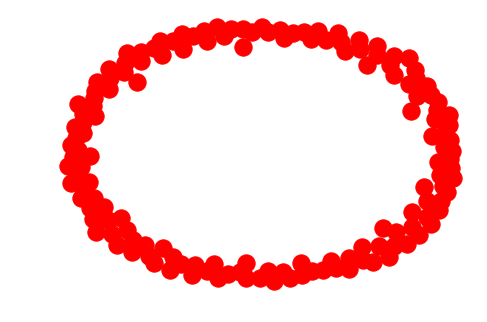

In [18]:
%matplotlib inline

# Visualize network
nx.draw(g)

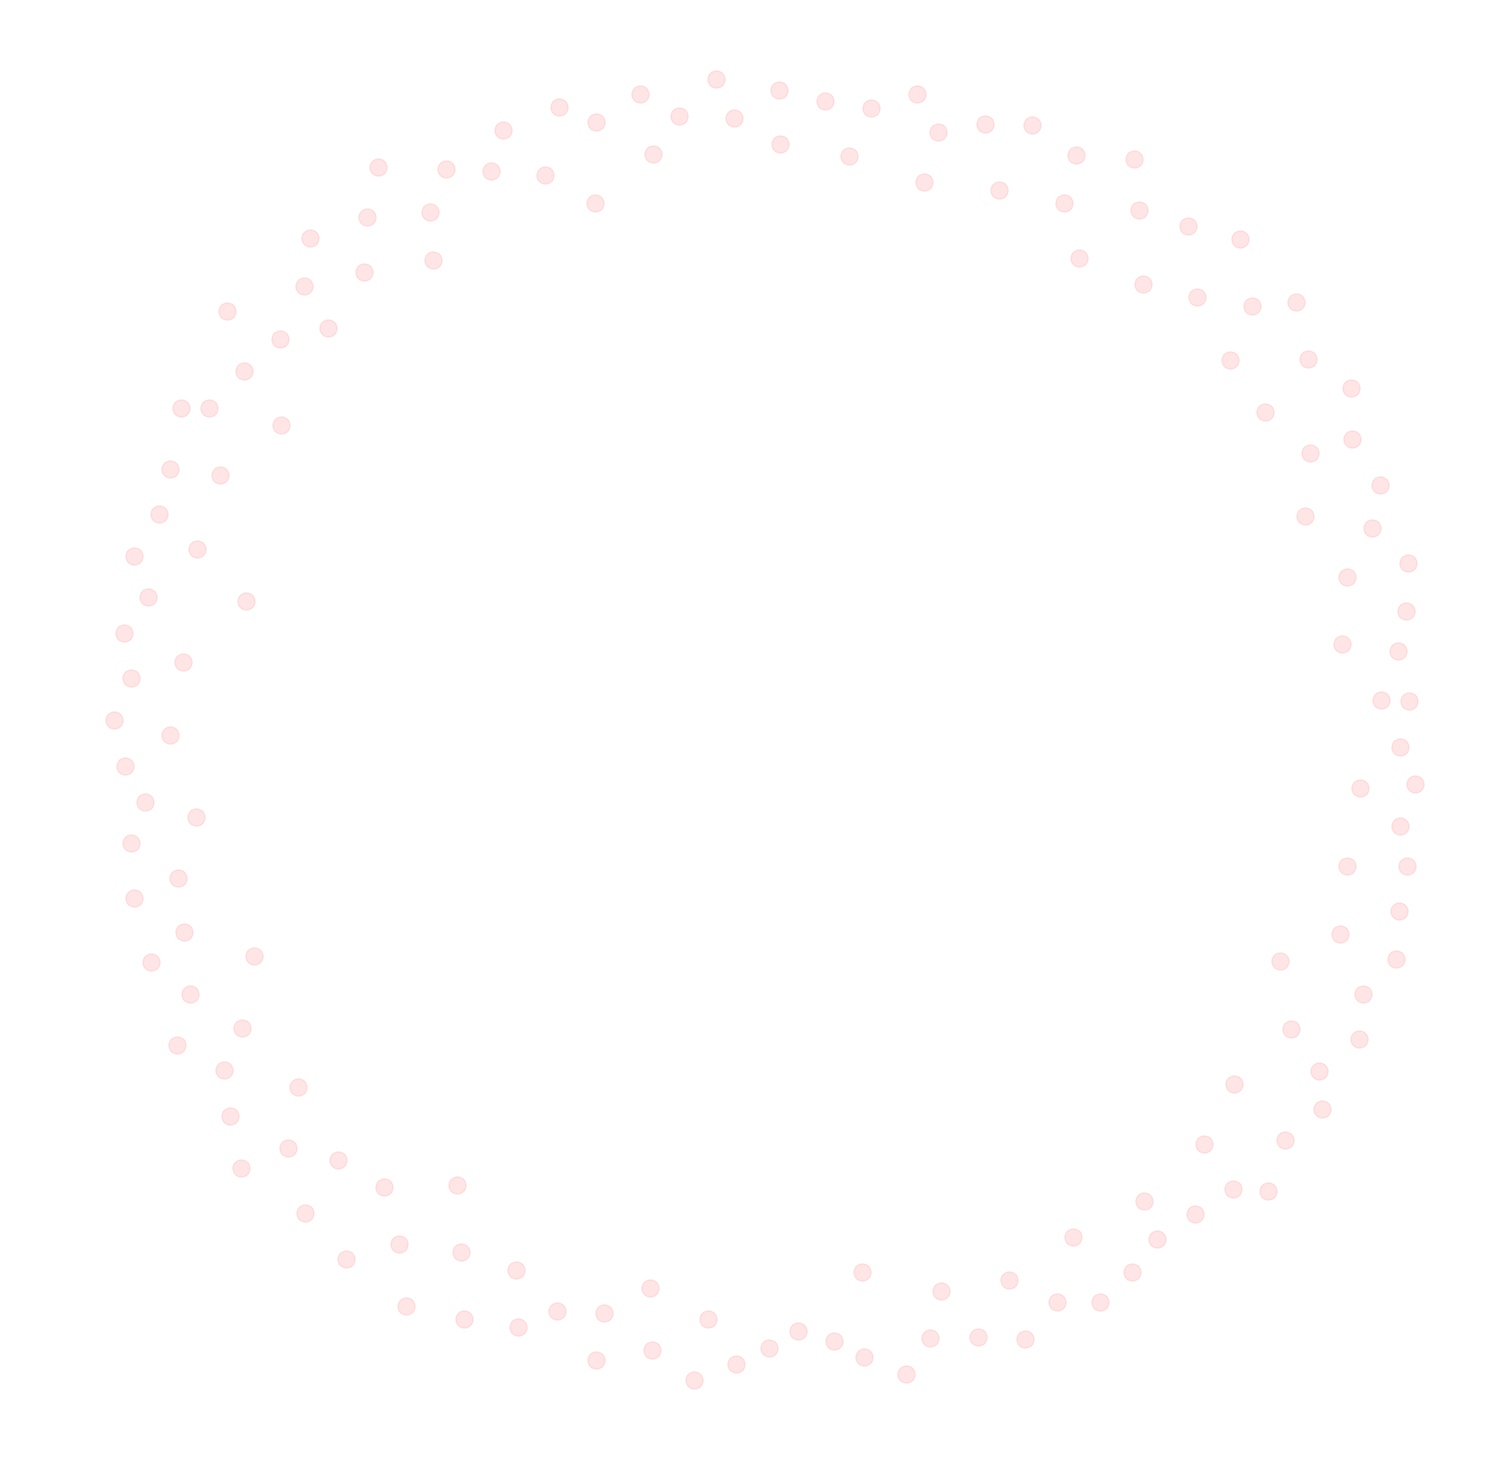

In [19]:
from matplotlib import pyplot as plt

plt.figure(3, figsize=(20,20))
nx.draw(g, alpha = 0.1, edge_color='b')

#### Creating a similarity graph

Recommend users, based on how many friends they share.
We are therefore going to take our existing graph (which has edges relating to friendship)
and create a new graph from its information.
The nodes are still users, but the edges are
going to be weighted edges. A weighted edge is simply an edge with a weight property.
The logic is that a higher weight indicates more similarity between the two nodes than a
lower weight. This is context-dependent. If the weights represent distance, then the lower
weights indicate more similarity.
This graph also has the property that it is
not directed. This is due to our similarity computation, where the similarity of user A to
user B is the same as the similarity of user B to user A.


##### Jaccard Similarity
We can normalize by
dividing by the total number of distinct friends the two have. The Jaccard Similarity, always between 0 and 1, represents the percentage overlap of the
two lists.

In [20]:
# Convert lists into sets
friends = {user: set(friends[user]) for user in friends}

# Compute similarity 
def compute_similarity(friends1, friends2):
    return len(friends1 & friends2) / (len(friends1 | friends2) + 1e-6) # ensure we do not divde by zero in case both users do not have any friends

In [21]:
def create_graph(followers, threshold=0):
    """Create weighted graph of the similarity between users"""
    g = nx.Graph()
    for user1 in friends.keys():
        for user2 in friends.keys():
            if user1 == user2:
                continue
            weight = compute_similarity(friends[user1], friends[user2])
            if weight >= threshold:
                g.add_node(user1)
                g.add_node(user2)
                g.add_edge(user1, user2, weight=weight)
    return g

In [22]:
# Create graph by calling the function
g = create_graph(friends)

plt.figure(figsize=(10,10))

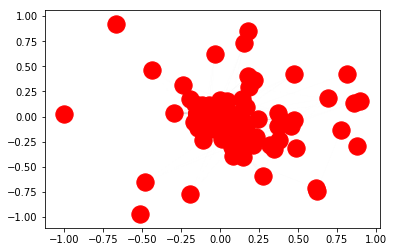

In [23]:
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos)
edgewidth = [ d['weight'] for (u,v,d) in g.edges(data=True)]
nx.draw_networkx_edges(g, pos, width=edgewidth)

#### Connected components

A connected component is a set of nodes in a graph that are connected via edges. Not all
nodes need to be connected to each other to be a connected component. However, for two
nodes to be in the same connected component, there needs to be a way to travel from one
node to another in that connected component by moving along edges.
Connected components do not consider edge weights when being
computed; they only check for the presence of an edge.

In [24]:
g = create_graph(friends, 0.1)
sub_graphs = nx.connected_component_subgraphs(g)

for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes())
    print("Subgraph {0} has {1} nodes".format(i, n_nodes))

Subgraph 0 has 2 nodes
Subgraph 1 has 69 nodes


In [25]:
# Alter the connected components by altering the threshold
g = create_graph(friends, 0.25)
sub_graphs = nx.connected_component_subgraphs(g)

for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes())
    print("Subgraph {0} has {1} nodes".format(i, n_nodes))

Subgraph 0 has 69 nodes


In [26]:
sub_graphs = nx.connected_component_subgraphs(g)
n_subgraphs = nx.number_connected_components(g)

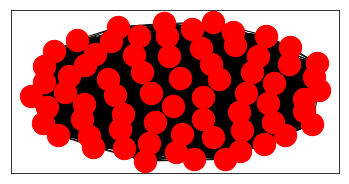

In [27]:
fig = plt.figure(figsize=(20, (n_subgraphs * 3)))
for i, sub_graph in enumerate(sub_graphs):
    ax = fig.add_subplot(int(n_subgraphs / 3) + 1, 3, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, sub_graph.nodes(), ax=ax, node_size = 500)
    nx.draw_networkx_edges(g, pos, sub_graph.edges(), ax=ax)

#### Optimizing criteria

##### Silhouette Coefficient

In [40]:
import numpy as np
from sklearn.metrics import silhouette_score

def compute_silouette(threshold, friends):
    g = create_graph(friends, threshold=threshold)
    if len(g.nodes()) < 2:
        return -99
    sub_graphs = nx.connected_component_subgraphs(g)
    
    if not(2 <= nx.number_connected_components(g) < len(g.nodes()) -1):
        return -99
    
    label_dict = {}
    for i, sub_graph in enumerate(sub_graphs):
        for node in sub_graph.nodes():
            label_dict[node] = i
    labels = np.array([label_dict[node] for node in g.nodes()])
    x = nx.to_scipy_sparse_matrix(g).todense()
    x = 1 - x
    return silhouette_score(x, labels, metric='precomputed')

In [41]:
def inverted_silhouette(threshold, friends):
    """This function creates a new function from an original function."""
    return -compute_silouette(threshold, friends)

In [42]:
from scipy.optimize import minimize

results = minimize(inverted_silhouette, 0.1, args=(friends,))